In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import cv2
import os
from PIL import Image
import urllib.request
import zipfile
import io

# 设置中文字体
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'Arial Unicode MS', 'DejaVu Sans']
matplotlib.rcParams['axes.unicode_minus'] = False

# 初始化变量
faces = []
original_faces = []
mean_face = None
eigenfaces = None
weights = None
explained_variance_ratio_ = None
face_height = None
face_width = None

In [4]:
output_dir = './att_faces'

# 创建输出目录
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 定义数据集URL
dataset_url = "https://www.cl.cam.ac.uk/research/dtg/attarchive/pub/data/att_faces.zip"

print("正在下载AT&T人脸数据库...")

#请完成数据集下载代码
# try:
#     with urllib.request.urlopen(dataset_url) as response:
#         with zipfile.ZipFile(io.BytesIO(response.read())) as zf:
#             # 查找解压后的主目录名
#             # 通常zip文件会有一个顶层文件夹，我们直接将内容解压到output_dir
#             zf.extractall(output_dir)
#             print(f"数据集已成功下载并解压到 '{output_dir}'")
#             # AT&T数据集解压后没有单一的顶层目录，而是直接s1, s2...
#             # 所以我们将dataset_dir设置为output_dir
#             dataset_dir = output_dir
# except Exception as e:
#     print(f"下载或解压失败: {e}")
#     dataset_dir = None

正在下载AT&T人脸数据库...


In [6]:
# 加载图像
if dataset_dir:
    max_subjects = 40
    images_per_subject = 10
    resize = (112, 92)
    
    face_height, face_width = resize
    images = []
    original_images = []
    
    subject_count = 0
    
    # 遍历所有人脸文件夹
    for s in range(1, min(max_subjects + 1, 41)):  # AT&T有40个人
        subject_dir = os.path.join(dataset_dir, f"s{s}")
        
        if not os.path.exists(subject_dir):
            print(f"目录 {subject_dir} 不存在，跳过")
            continue
        
        image_count = 0
        
        # 遍历该人的所有图像
        for i in range(1, images_per_subject + 1):
            image_path = os.path.join(subject_dir, f"{i}.pgm")
            
            if not os.path.exists(image_path):
                print(f"图像 {image_path} 不存在，跳过")
                continue
            
            try:
                # 读取图像(PGM格式)
                img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                
                if img is not None:
                    # 保存原始图像
                    original_images.append(img)
                    
                    # 如果需要调整大小
                    if resize != (112, 92):
                        img = cv2.resize(img, resize)
                    
                    # 展平为一维向量
                    images.append(img.flatten())
                    image_count += 1
            except Exception as e:
                print(f"加载图像 {image_path} 时出错: {e}")
        
        print(f"已加载主体 {s} 的 {image_count} 张图像")
        subject_count += 1
        
        if subject_count >= max_subjects:
            break
    
    if not images:
        raise ValueError("未找到有效的图像文件")
    
    # 转换为NumPy数组
    faces = np.array(images)
    original_faces = original_images
    
    print(f"总共加载了 {len(images)} 张图像")

已加载主体 1 的 10 张图像
已加载主体 2 的 10 张图像
已加载主体 3 的 10 张图像
已加载主体 4 的 10 张图像
已加载主体 5 的 10 张图像
已加载主体 6 的 10 张图像
已加载主体 7 的 10 张图像
已加载主体 8 的 10 张图像
已加载主体 9 的 10 张图像
已加载主体 10 的 10 张图像
已加载主体 11 的 10 张图像
已加载主体 12 的 10 张图像
已加载主体 13 的 10 张图像
已加载主体 14 的 10 张图像
已加载主体 15 的 10 张图像
已加载主体 16 的 10 张图像
已加载主体 17 的 10 张图像
已加载主体 18 的 10 张图像
已加载主体 19 的 10 张图像
已加载主体 20 的 10 张图像
已加载主体 21 的 10 张图像
已加载主体 22 的 10 张图像
已加载主体 23 的 10 张图像
已加载主体 24 的 10 张图像
已加载主体 25 的 10 张图像
已加载主体 26 的 10 张图像
已加载主体 27 的 10 张图像
已加载主体 28 的 10 张图像
已加载主体 29 的 10 张图像
已加载主体 30 的 10 张图像
已加载主体 31 的 10 张图像
已加载主体 32 的 10 张图像
已加载主体 33 的 10 张图像
已加载主体 34 的 10 张图像
已加载主体 35 的 10 张图像
已加载主体 36 的 10 张图像
已加载主体 37 的 10 张图像
已加载主体 38 的 10 张图像
已加载主体 39 的 10 张图像
已加载主体 40 的 10 张图像
总共加载了 400 张图像


In [7]:
# 计算PCA
if len(faces) > 0:
    n_components = 100
    
    # 1. 计算平均脸
    mean_face = np.mean(faces, axis=0)
    
    # 2. 中心化数据（减去平均脸）
    centered_faces = faces - mean_face
    
    # 3. 使用SVD分解，计算特征值和特征向量
    U, S, Vt = np.linalg.svd(centered_faces, full_matrices=False)
    
    # 特征脸是右奇异向量 (V)
    eigenfaces = Vt[:n_components]
    
    # 奇异值S与特征值相关 (eigenvalues = S^2 / (n_samples-1))
    eigenvalues = S**2
    
    # 4. 计算解释方差比
    total_var = np.sum(eigenvalues)
    explained_variance_ratio_ = eigenvalues / total_var

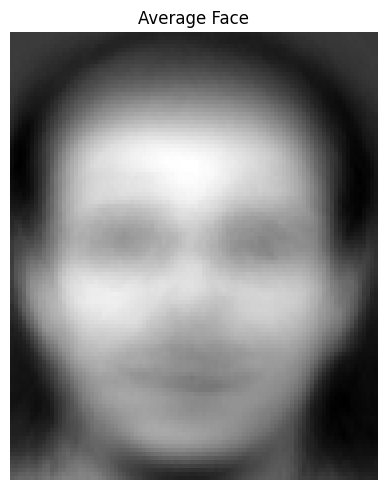

In [8]:
# 可视化平均脸
if mean_face is not None:
    plt.figure(figsize=(5, 5))
    plt.imshow(mean_face.reshape(face_height, face_width), cmap='gray')
    plt.title('Average Face')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

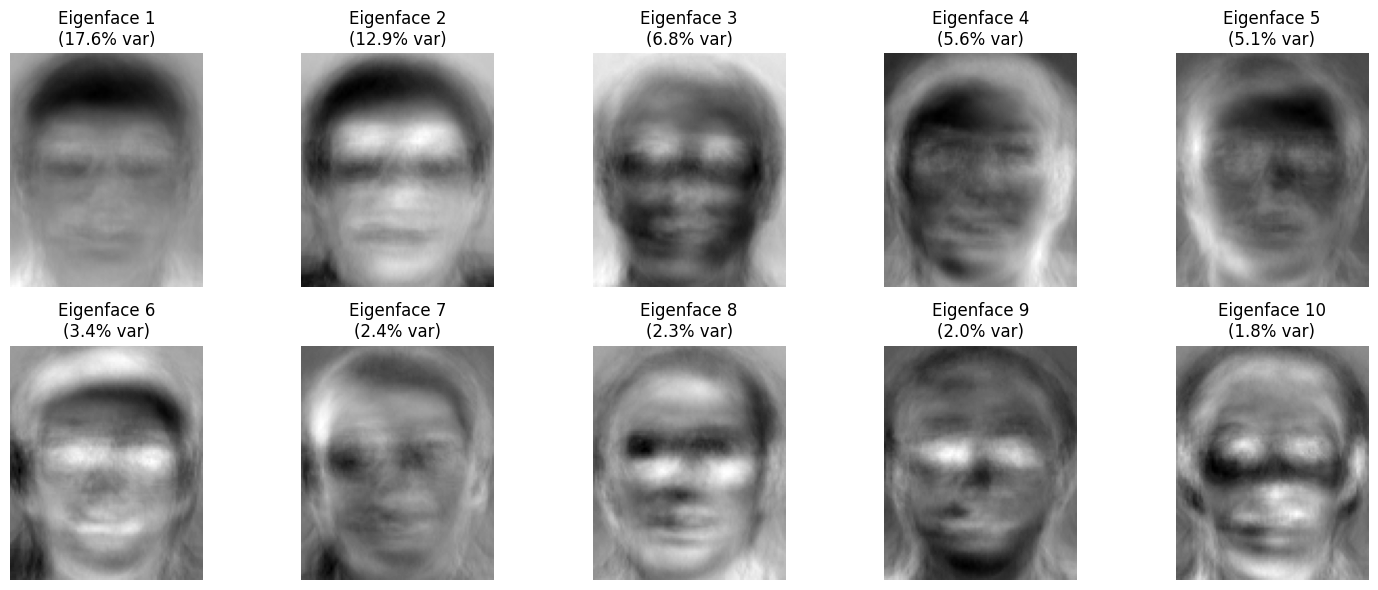

In [9]:
# 可视化特征脸
if eigenfaces is not None:
    n = min(10, len(eigenfaces))
    rows = (n + 4) // 5  # 每行最多5个图像
    
    plt.figure(figsize=(15, 3 * rows))
    
    for i in range(n):
        plt.subplot(rows, 5, i + 1)
        
        # 对特征脸进行归一化以便可视化
        eigenface = eigenfaces[i].reshape(face_height, face_width)
        
        # 计算最小值和最大值以进行归一化
        min_val = np.min(eigenface)
        max_val = np.max(eigenface)
        
        # 归一化到[0, 1]范围
        if max_val > min_val:
            eigenface = (eigenface - min_val) / (max_val - min_val)
        
        plt.imshow(eigenface, cmap='gray')
        
        variance = explained_variance_ratio_[i] * 100
        plt.title(f'Eigenface {i+1}\n({variance:.1f}% var)')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()